# Train

In [ ]:
#@title import
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title single session
class singleSession(Dataset):
  def __init__(self,subj,session):
    # Load data
    fn = "drive/MyDrive/bciData/rwt_subject_"+str(subj)+"_session_"+str(session)+".csv"
    f = pd.read_csv(fn,header=None) 
    # switch rows
    a,b,c,d,e = f.iloc[0:600].copy(),f.iloc[600:1200].copy(),f.iloc[1200:1800].copy(),f.iloc[1800:2400].copy(),f.iloc[2400:3000].copy()
    if (session==1): f = f
    elif (session==2): f.iloc[0:600],f.iloc[600:1200],f.iloc[1200:1800],f.iloc[1800:2400],f.iloc[2400:3000] = c.values,a.values,d.values,b.values,e.values,
    elif (session==3): f.iloc[0:600],f.iloc[600:1200],f.iloc[1200:1800],f.iloc[1800:2400],f.iloc[2400:3000] = d.values,b.values,c.values,e.values,a.values,
    elif (session==4): f.iloc[0:600],f.iloc[600:1200],f.iloc[1200:1800],f.iloc[1800:2400],f.iloc[2400:3000] = e.values,d.values,c.values,b.values,a.values,
    elif (session==5): f.iloc[0:600],f.iloc[600:1200],f.iloc[1200:1800],f.iloc[1800:2400],f.iloc[2400:3000] = b.values,c.values,e.values,a.values,d.values,
    elif (session==6): f.iloc[0:600],f.iloc[600:1200],f.iloc[1200:1800],f.iloc[1800:2400],f.iloc[2400:3000] = d.values,e.values,a.values,c.values,b.values,
    # construct df, skip data containing 0
    f = f.to_numpy()
    self.x = [np.asarray(f[j:j+10]) for j in range(0,3000,10) if all(f[j:j+10,0]!=0)]
    self.y = [j//600 for j in range(0,3000,10) if all(f[j:j+10,0]!=0)]
  def __len__(self):
    return len(self.x)
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]

subj = 1
session = 1
ds = singleSession(subj,session)
train_size = int(0.9 * len(ds))
test_size = len(ds) - train_size
dataset_train, dataset_test = torch.utils.data.random_split(ds, [train_size, test_size])
dataloader_train = DataLoader(dataset_train, shuffle=True)
dataloader_test = DataLoader(dataset_test, shuffle=True)

In [ ]:
#@title model
class Time_Attention(nn.Module):
  def __init__(self):
    # input: 10*20
    super(Time_Attention, self).__init__()
    self.position = nn.Linear(10,10)
    self.values = nn.Linear(20,20, bias=False)
    self.keys = nn.Linear(20,20, bias=False)
    self.queries = nn.Linear(20,20, bias=False)
    
  def forward(self, x):
    p = torch.arange(10)
    embed = x.view(10,20)+self.position(p.float()).view(10,1)
    values=keys=queries=embed
    values,keys,queries = self.values(values.float()),self.keys(keys.float()),self.queries(queries.float())  
    attention = torch.softmax(torch.einsum("qx,ky->xy", [queries,keys]),dim=1)
    out = torch.einsum("xy,vn->vy", [attention,values])
    return embed,out

class Channel_Attention(nn.Module):
  def __init__(self):
    # input: 20*10
    super(Channel_Attention, self).__init__()
    self.position = nn.Linear(20,20)
    self.values = nn.Linear(10,10, bias=False)
    self.keys = nn.Linear(10,10, bias=False)
    self.queries = nn.Linear(10,10, bias=False)
    
  def forward(self, x):
    p = torch.arange(20)
    embed = x.view(20,10)+self.position(p.float()).view(20,1)
    values=keys=queries=embed
    values,keys,queries = self.values(values.float()),self.keys(keys.float()),self.queries(queries.float())  
    attention = torch.softmax(torch.einsum("qx,ky->xy", [queries,keys]),dim=1)
    out = torch.einsum("xy,vn->vy", [attention,values])
    return embed,out


class Model(nn.Module):
  def __init__(self,device="cpu"): 
    super(Model, self).__init__()
    self.time_attention = Time_Attention()
    self.channel_attention = Channel_Attention()
    self.time_expand = nn.Sequential(nn.Linear(20,40),nn.ReLU(),nn.Linear(40,20))
    self.channel_expand = nn.Sequential(nn.Linear(10,20),nn.ReLU(),nn.Linear(20,10))
    self.norm1 = nn.LayerNorm(20)
    self.norm2 = nn.LayerNorm(10)
    self.fc1 = nn.Linear(20,20)
    self.fc2 = nn.Linear(20*10, 5)
    self.device = device

  def forward(self, x):
    embed1,attention1 = self.time_attention(x)
    attention1 = self.time_expand(attention1)
    embed2,attention2 = self.channel_attention(torch.transpose(X,1,2))
    attention2 = self.channel_expand(attention2)
    attention1 = self.norm1((attention1+embed1).float())
    attention2 = self.norm2((attention2+embed2).float())
    attention = attention1
    x = self.fc1(attention)
    x = torch.flatten(x)
    x = self.fc2(x)
    out = torch.softmax(x,dim=-1)
    return out.unsqueeze(0)

In [ ]:
#@title train
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() 
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs)
for epoch in range(epochs):
  print(f"Epoch {epoch+1}")

  model.train()
  train_loss = 0;
  for i,(X, y) in enumerate(dataloader_train):
    X, y = X.to(device), y.to(device)
    pred = model(X)
    loss = criterion(pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_losses[epoch] = train_loss/(i+1)

  model.eval()
  test_loss, correct = 0, 0
  confusion_matrix = np.zeros([5, 5])
  for i,(X, y) in enumerate(dataloader_test):
    X, y = X.to(device), y.to(device)
    # X = np.transpose(X.squeeze(0)).unsqueeze(0)
    with torch.no_grad():
      pred = model(X)
      test_loss += criterion(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      confusion_matrix[pred.argmax(1)][y] += 1
  print("accuracy",str(correct/(i+1)),'\n')
  test_losses[epoch] = test_loss/(i+1)

Epoch 1
accuracy 0.32142857142857145 

Epoch 2
accuracy 0.39285714285714285 

Epoch 3
accuracy 0.42857142857142855 

Epoch 4
accuracy 0.42857142857142855 

Epoch 5
accuracy 0.4642857142857143 

Epoch 6
accuracy 0.6071428571428571 

Epoch 7
accuracy 0.5 

Epoch 8
accuracy 0.4642857142857143 

Epoch 9
accuracy 0.6428571428571429 

Epoch 10
accuracy 0.6071428571428571 

Epoch 11
accuracy 0.5 

Epoch 12
accuracy 0.5357142857142857 

Epoch 13
accuracy 0.6071428571428571 

Epoch 14
accuracy 0.6071428571428571 

Epoch 15
accuracy 0.6071428571428571 

Epoch 16
accuracy 0.75 

Epoch 17
accuracy 0.7142857142857143 

Epoch 18
accuracy 0.8214285714285714 

Epoch 19
accuracy 0.75 

Epoch 20
accuracy 0.7142857142857143 

Epoch 21
accuracy 0.75 

Epoch 22
accuracy 0.6785714285714286 

Epoch 23
accuracy 0.7142857142857143 

Epoch 24
accuracy 0.7142857142857143 

Epoch 25
accuracy 0.7857142857142857 

Epoch 26
accuracy 0.7142857142857143 

Epoch 27
accuracy 0.7857142857142857 

Epoch 28
accuracy 0.5714

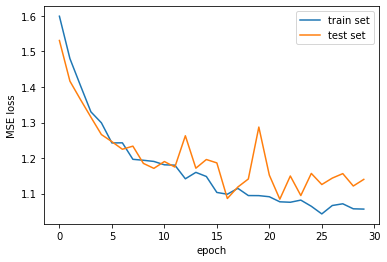

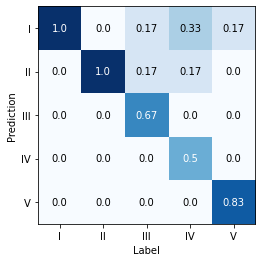

In [ ]:
#@title plot
plt.figure(1)
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(["train set","test set"])
plt.xlabel("epoch")
plt.ylabel("MSE loss")

plt.figure(2)
confusion_matrix = confusion_matrix/sum(confusion_matrix)
plt.imshow(confusion_matrix,cmap='Blues')
for i in range(5):
  for j in range(5):
    if(i==j):
      text = plt.gca().text(j,i,round(confusion_matrix[i,j],2), ha="center", va="center", color="w")
    else:
      text = plt.gca().text(j,i,round(confusion_matrix[i,j],2), ha="center", va="center", color="black")
plt.xlabel("Label")
plt.xticks([0,1,2,3,4],["I","II","III","IV","V"])
plt.ylabel("Prediction")
plt.yticks([0,1,2,3,4],["I","II","III","IV","V"])
plt.show()

In [ ]:
#@title save
# torch.save({
# 'model_state_dict': model.state_dict(),
# 'optimizer_state_dict': optimizer.state_dict(),
# 'loss': test_losses,
# }, 'model_epoch15.pth')

# model = Model()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)
# checkpoint = torch.load('model_epoch15.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# Interpret

In [ ]:
#@title copy parameters
for name, param in model.named_parameters():
   if (name=="time_attention.position.weight"):t_p_w = param.clone().detach()
   elif (name=="time_attention.position.bias"):t_p_b = param.clone().detach()
   elif (name=="time_attention.values.weight"):t_values_w = param.clone().detach()
   elif (name=="time_attention.keys.weight"):t_keys_w = param.clone().detach()
   elif (name=="time_attention.queries.weight"):t_queries_w = param.clone().detach()
   elif (name=="channel_attention.position.weight"):c_p_w = param.clone().detach()
   elif (name=="channel_attention.position.bias"):c_p_b = param.clone().detach()
   elif (name=="channel_attention.values.weight"):c_values_w = param.clone().detach()
   elif (name=="channel_attention.keys.weight"):c_keys_w = param.clone().detach()
   elif (name=="channel_attention.queries.weight"):c_queries_w = param.clone().detach()
   elif (name=="norm1.weight"):n1_w = param.clone().detach()
   elif (name=="norm1.bias"):n1_b = param.clone().detach()
   elif (name=="norm2.weight"):n2_w = param.clone().detach()
   elif (name=="norm2.bias"):n2_b = param.clone().detach()
   elif (name=="feed_forward.0.weight"):ff0_w = param.clone().detach()
   elif (name=="feed_forward.0.bias"):ff0_b = param.clone().detach()
   elif (name=="feed_forward.2.weight"):ff2_w = param.clone().detach()
   elif (name=="feed_forward.2.bias"):ff2_b = param.clone().detach()
   elif (name=="fc1.weight"):fc1_w = param.clone().detach()
   elif (name=="fc1.bias"):fc1_b = param.clone().detach()
   elif (name=="fc2.weight"):fc2_w = param.clone().detach()
   elif (name=="fc2.bias"):fc2_b = param.clone().detach()
   elif (name=="s_attention.position.weight"):Sp_w = param.clone().detach()
   elif (name=="s_attention.position.bias"):Sp_b = param.clone().detach()
   elif (name=="s_attention.values.weight"):Sv_w = param.clone().detach()
   elif (name=="s_attention.keys.weight"):Sk_w = param.clone().detach()
   elif (name=="s_attention.queries.weight"):Sq_w = param.clone().detach()
   elif (name=="t_attention.values.weight"):Tv_w = param.clone().detach()
   elif (name=="t_attention.keys.weight"):Tk_w = param.clone().detach()
   elif (name=="t_attention.queries.weight"):Tq_w = param.clone().detach()

tensor([[9.7928e-01, 2.9094e-03, 1.4634e-05, 1.7797e-02, 1.9998e-08]]) tensor([2])


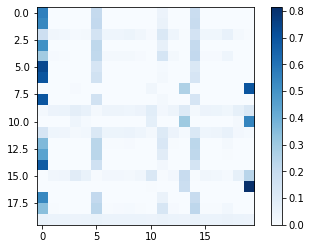

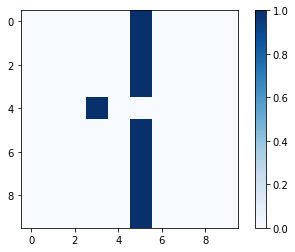

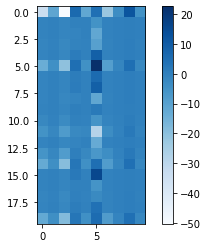

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


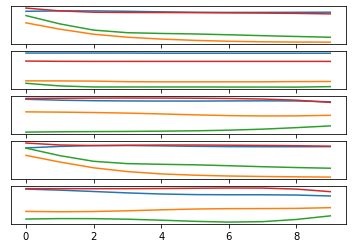

In [ ]:
#@title visualize attention
with torch.no_grad():
  X,y = next(iter(dataloader_train))
  print(model(X),y)

  p = torch.arange(10)
  positions = torch.matmul(p.float(),t_p_w.t())+t_p_b
  embed = X.view(10,20)+positions.view(10,1)
  values=keys=queries=embed
  values = torch.matmul(values.float(),t_values_w.t())
  keys = torch.matmul(keys.float(),t_keys_w.t())
  queries = torch.matmul(queries.float(),t_queries_w.t())
  energy = torch.einsum("qx,ky->xy", [queries,keys])
  attention1 = torch.softmax(energy,dim=1)
  out1 = torch.einsum("xy,vn->vy", [attention1,values])

  p = torch.arange(20)
  positions = torch.matmul(p.float(),c_p_w.t())+c_p_b
  embed = torch.transpose(X,1,2).view(20,10)+positions.view(20,1)
  values=keys=queries=embed
  values = torch.matmul(values.float(),c_values_w.t())
  keys = torch.matmul(keys.float(),c_keys_w.t())
  queries = torch.matmul(queries.float(),c_queries_w.t())
  energy = torch.einsum("qx,ky->xy", [queries,keys])
  attention2 = torch.softmax(energy,dim=1)
  out2 = torch.einsum("xy,vn->vy", [attention2,values])

plt.imshow(attention1,cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(attention2,cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()
plt.imshow(out1.t()+out2,cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()

X = X.squeeze(0)
for i in range(5):
  plt.subplot(5,1,i+1)
  for j in range(4):
    # plt.xticks()
    plt.yticks([])
    plt.plot(X[:,i*4+j])
X = torch.tensor(X)

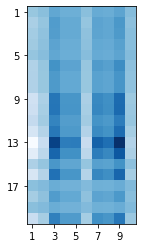

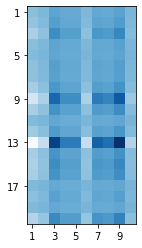

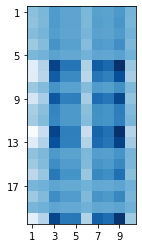

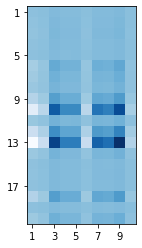

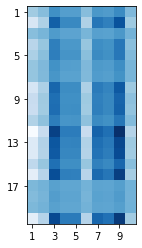

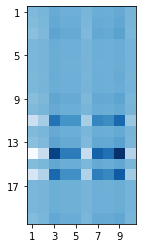

In [ ]:
#@title For each task: attention in average
O,O1,O2,O3,O4,O5=np.zeros([10,20]),np.zeros([10,20]),np.zeros([10,20]),np.zeros([10,20]),np.zeros([10,20]),np.zeros([10,20])
for X,y in dataloader_train:
  p = torch.arange(1, 11)
  positions = torch.matmul(p.float(),p_w.t())+p_b
  embed = X.view(10,20)+positions.view(10,1)
  values=keys=queries=embed
  values = torch.matmul(values.float(),values_w.t())
  keys = torch.matmul(keys.float(),keys_w.t())
  queries = torch.matmul(queries.float(),queries_w.t())
  energy = torch.einsum("qx,ky->xy", [queries,keys])
  attention = torch.softmax(energy,dim=1)
  out = torch.einsum("xy,vn->vy", [attention,values])
  O+=np.asarray(out)
  if y==0: O1+=np.asarray(out);
  elif y==1: O2+=np.asarray(out);
  elif y==2: O3+=np.asarray(out);
  elif y==3: O4+=np.asarray(out);
  elif y==4: O5+=np.asarray(out);


def plot(O):
  plt.imshow(np.transpose(O),cmap='Blues', interpolation='nearest')
  plt.xticks([0,2,4,6,8],labels=[1,3,5,7,9])
  plt.yticks([0,4,8,12,16],labels=[1,5,9,13,17])
  plt.show()

plot(O)
plot(O1)
plot(O2)
plot(O3)
plot(O4)
plot(O5)


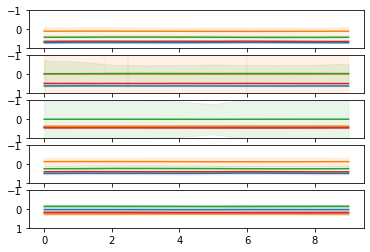

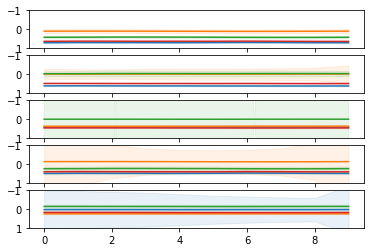

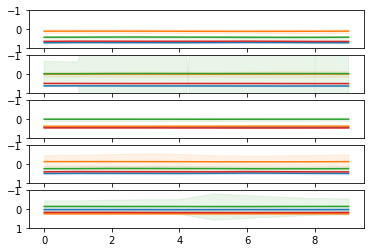

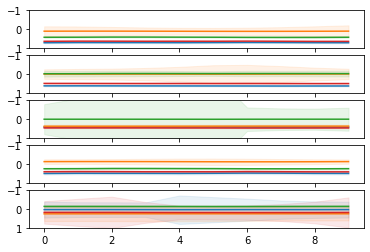

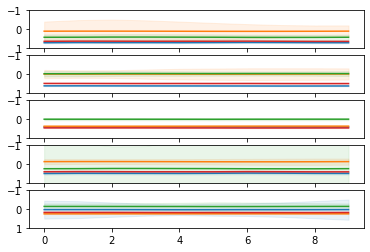

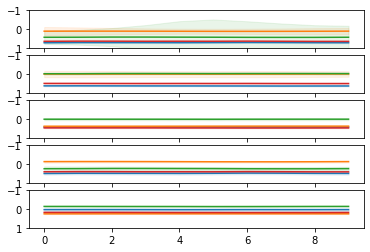

In [ ]:
#@title For each task: brainwave in CI
f_0=f_1=f_2=f_3=f_4=f_5=True
for x,y in dataloader_train:
  x = np.reshape(x,[1,10,20])
  if y==0:
    if f_1: T_1 = x; f_1 = False
    else: T_1 = np.append(T_1,x,axis=0)
  elif y==1:
    if f_2: T_2 = x; f_2 = False
    else: T_2 = np.append(T_2,x,axis=0)
  elif y==2:
    if f_3: T_3 = x; f_3 = False
    else: T_3 = np.append(T_3,x,axis=0)
  elif y==3:
    if f_4: T_4 = x; f_4 = False
    else: T_4 = np.append(T_4,x,axis=0)
  elif y==4:
    if f_5: T_5 = x; f_5 = False
    else: T_5 = np.append(T_5,x,axis=0)
  if f_0: T_0 = x; f_0 = False
  else: T_0 = np.append(T_0,x,axis=0)

def subp(i,T):
  plt.figure(i)
  C = 0.05*np.std(T,axis=0)/np.mean(T,axis=0)
  X = np.mean(T_0,axis=0)
  for i in range(5):
    plt.subplot(5,1,i+1)
    for j in range(4):
      l = X[:,i*4+j]
      c = C[:,i*4+j]
      p = plt.plot(l)
      col = p[0].get_color()
      plt.fill_between(list(range(0,10)),(l-c),(l+c), color=col, alpha=0.1)
      plt.ylim(1,-1)
subp(0,T_0)
subp(1,T_1)
subp(2,T_2)
subp(3,T_3)
subp(4,T_4)
subp(5,T_5)
